## 第十九次课后练习-自编码器与预训练模型

**负责助教：王瑞环**
<span style="color:red; font-weight:bold;">请将作业文件命名为 第十九次课后练习+姓名+学号.ipynb, 例如 第十九次课后练习+张三+1000000000.ipynb</span>

<span style="color:red; font-weight:bold;">在作业过程中觉得有心得或者自己拓展学习到有价值内容的，可以在文件名最后加一个#号。例如第十九次课后练习+张三+1000000000+#.ipynb</span>

对于本次课内容有拓展学习需要的同学，推荐Lilian Weng的blog文章
- [From Autoencoder to Beta-VAE](https://lilianweng.github.io/posts/2018-08-12-vae/)
- [Attention? Attention!](https://lilianweng.github.io/posts/2018-06-24-attention/)
- [The Transformer Family](https://lilianweng.github.io/posts/2020-04-07-the-transformer-family/)
- [Generalized Language Models](https://lilianweng.github.io/posts/2019-01-31-lm)

## 第一部分 变分自编码器

阅读以下代码，结合课件内容，理解变分自编码器的原理和实现方法。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

**Step 1. 数据准备**：使用MNIST手写数字数据集的训练集

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

x = next(iter(train_loader))[0]
print(x.shape)
print(x.min(), x.max())

torch.Size([128, 784])
tensor(0.) tensor(1.)


**Step 2. 定义网络结构**：使用线性层和ReLU实现编码器和解码器

编码器的输入为图像，输出为均值和对数方差。

解码器的输入为一个高斯分布的采样，输出为重构的图像。

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super().__init__()
        
        # 编码器
        self.fc_enc = nn.Linear(input_dim, hidden_dim)
        self.act_enc = nn.ReLU()
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # 解码器
        self.fc_dec = nn.Linear(latent_dim, hidden_dim)
        self.act_dec = nn.ReLU()
        self.fc_out = nn.Linear(hidden_dim, input_dim)

    # 编码函数，将输入数据映射为均值和对数方差
    def encode(self, x):
        h = self.act_enc(self.fc_enc(x))
        return self.fc_mu(h), self.fc_logvar(h)

    # 重参数化技术，根据给定的均值和对数方差采样一个高斯分布的样本
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    # 解码函数，将潜在变量映射回原始数据空间
    # 由于原始数据是 0-1 之间的像素值，我们在解码时
    # 使用 sigmoid 函数将输出限制在 0-1 之间
    def decode(self, z):
        h = self.act_dec(self.fc_dec(z))
        return torch.sigmoid(self.fc_out(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

**Step 3. 定义损失函数**：VAE的损失函数由两部分组成

重构损失用于衡量解码器输出与原始输入之间的差异，可以用均方误差（MSE）或二元交叉熵（BCE）等

KL损失用于衡量标准正态分布与编码器输出的分布之间的差异，使用KL散度来计算

**注**：KL散度是信息论中用于衡量两个概率分布差距的度量方式，对于两个连续分布$P$和$Q$，用$Q$替代$P$所产生的信息损失为

$$
D_{KL}(P||Q) = \int_{-\infty}^{\infty} P(x) \log \frac{P(x)}{Q(x)} dx
$$

可以证明，当$P\sim \mathcal{N}(\mu, \sigma^2)$，$Q\sim \mathcal{N}(0, 1)$时，KL散度计算得

$$
D_{KL}(P||Q) = \frac{1}{2} \left( \sigma^2 + \mu^2 - \log \sigma^2 - 1 \right)
$$

In [4]:
def vae_loss(recon, x, mu, logvar):
    batch_size = x.size(0)
    recon_loss = F.binary_cross_entropy(recon, x, reduction='sum') / batch_size
    kl = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1) / batch_size
    return recon_loss + kl, recon_loss, kl

**Step 4. 训练VAE**

Epoch 1/10: 100%|██████████| 469/469 [00:01<00:00, 242.97it/s]


Epoch 1: Loss=164.7421, Recon Loss=149.5765, KL Loss=15.1656


Epoch 2/10: 100%|██████████| 469/469 [00:01<00:00, 239.39it/s]


Epoch 2: Loss=121.6262, Recon Loss=99.4848, KL Loss=22.1414


Epoch 3/10: 100%|██████████| 469/469 [00:01<00:00, 242.65it/s]


Epoch 3: Loss=114.5092, Recon Loss=90.6152, KL Loss=23.8940


Epoch 4/10: 100%|██████████| 469/469 [00:01<00:00, 242.61it/s]


Epoch 4: Loss=111.5115, Recon Loss=87.0183, KL Loss=24.4932


Epoch 5/10: 100%|██████████| 469/469 [00:01<00:00, 252.98it/s]


Epoch 5: Loss=109.7371, Recon Loss=84.9688, KL Loss=24.7683


Epoch 6/10: 100%|██████████| 469/469 [00:01<00:00, 237.81it/s]


Epoch 6: Loss=108.6033, Recon Loss=83.6796, KL Loss=24.9238


Epoch 7/10: 100%|██████████| 469/469 [00:02<00:00, 212.83it/s]


Epoch 7: Loss=107.7357, Recon Loss=82.7312, KL Loss=25.0046


Epoch 8/10: 100%|██████████| 469/469 [00:01<00:00, 254.65it/s]


Epoch 8: Loss=107.1062, Recon Loss=81.9730, KL Loss=25.1332


Epoch 9/10: 100%|██████████| 469/469 [00:01<00:00, 268.15it/s]


Epoch 9: Loss=106.6208, Recon Loss=81.4464, KL Loss=25.1745


Epoch 10/10: 100%|██████████| 469/469 [00:01<00:00, 266.46it/s]

Epoch 10: Loss=106.1907, Recon Loss=80.9740, KL Loss=25.2166


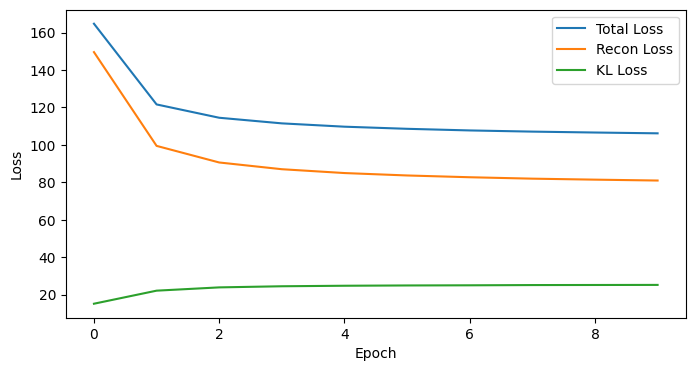

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

history = {'avg_loss': [], 'avg_recon_loss': [], 'avg_kl_loss': []}
model.train()
for epoch in range(1, epochs+1):
    avg_loss = avg_recon_loss = avg_kl_loss = 0
    
    ################################################################
    ## TODO: 补充模型训练和 history 记录更新的代码
    for x, _ in tqdm(train_loader, 
                     desc=f"Epoch {epoch}/{epochs}", 
                     total=len(train_loader)):
        x = x.to(device)
        
        optimizer.zero_grad()
        # forward
        recon, mu, logvar = model(x)
        # loss
        loss, recon_loss, kl_loss = vae_loss(recon, x, mu, logvar)
        avg_loss += loss.item()
        avg_recon_loss += recon_loss.item()
        avg_kl_loss += kl_loss.item()
        # backward
        loss.backward() # 先backward再step！！
        optimizer.step()
    avg_loss /= len(train_loader)
    avg_recon_loss /= len(train_loader)
    avg_kl_loss /= len(train_loader)
    ################################################################
    
    history['avg_loss'].append(avg_loss)
    history['avg_recon_loss'].append(avg_recon_loss)
    history['avg_kl_loss'].append(avg_kl_loss)
    print(f"Epoch {epoch}: Loss={avg_loss:.4f}, Recon Loss={avg_recon_loss:.4f}, KL Loss={avg_kl_loss:.4f}")
    

plt.figure(figsize=(8,4))
plt.plot(history['avg_loss'], label='Total Loss')
plt.plot(history['avg_recon_loss'], label='Recon Loss')
plt.plot(history['avg_kl_loss'], label='KL Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

**Step 5. 模型测试**：对训练集中的图像进行编码和解码，观察重构效果

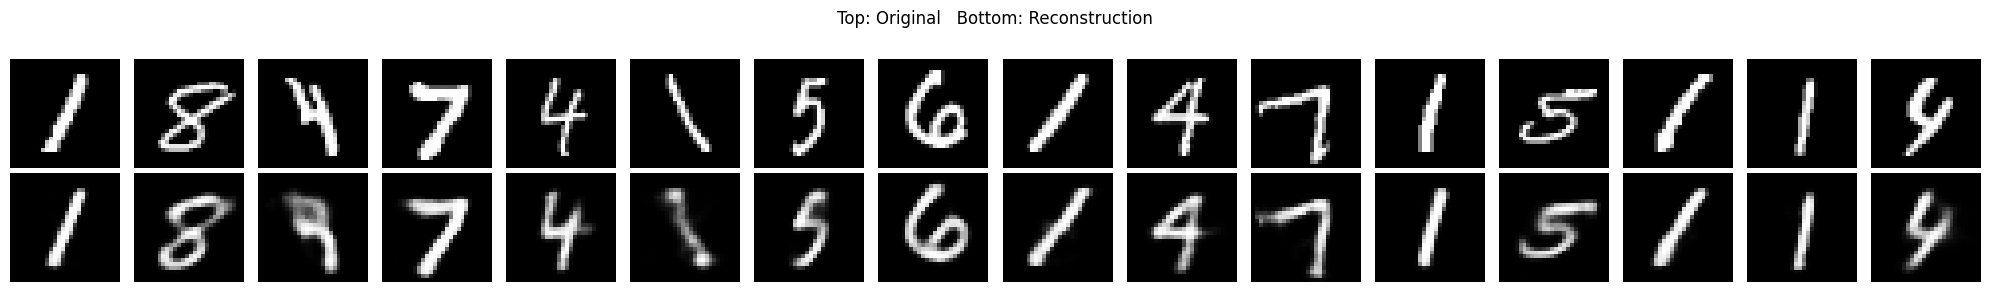

In [12]:
model.eval()

x_test, _ = next(iter(train_loader))
x_sample = x_test[:16].to(device)
with torch.no_grad():
    recon, _, _ = model(x_sample)

fig, axes = plt.subplots(2, 16, figsize=(20,3))
for i in range(16):
    axes[0,i].imshow(x_sample[i].cpu().view(28,28), cmap='gray')
    axes[0,i].axis('off')
    axes[1,i].imshow(recon[i].cpu().detach().view(28,28), cmap='gray')
    axes[1,i].axis('off')
plt.suptitle('Top: Original   Bottom: Reconstruction')
plt.tight_layout()
plt.show()

**Step 6. 图像生成**：直接从标准正态分布采样，使用解码器生成新图像

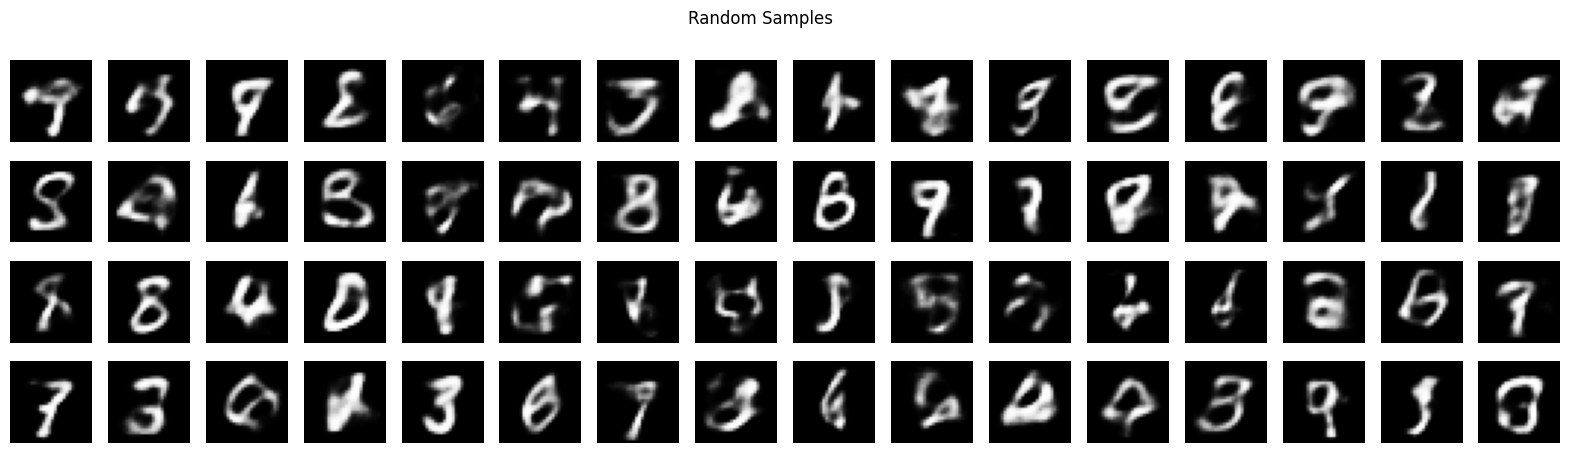

In [16]:
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    samples = model.decode(z)

fig, axes = plt.subplots(4, 16, figsize=(20,5))
for i in range(64):
    axes[i//16, i%16].imshow(samples[i].cpu().view(28,28), cmap='gray')
    axes[i//16, i%16].axis('off')
plt.suptitle('Random Samples'); plt.show()

观察两个高斯分布的采样间进行线性插值的生成效果

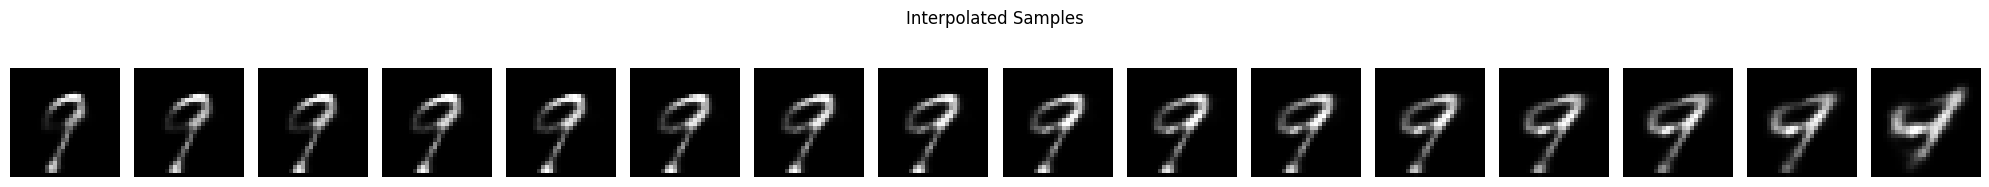

In [21]:
z1 = torch.randn(1, 20)
z2 = torch.randn(1, 20)
weights = np.linspace(0, 1, 16)
z = torch.stack([z1 * np.sqrt(1 - w) + z2 * np.sqrt(w) for w in weights]).to(device)
with torch.no_grad():
    interpolated_samples = model.decode(z)
fig, axes = plt.subplots(1, 16, figsize=(20,2))
for i in range(16):
    axes[i].imshow(interpolated_samples[i].cpu().view(28,28), cmap='gray')
    axes[i].axis('off')
plt.suptitle('Interpolated Samples')
plt.tight_layout()
plt.show()

## 第二部分 变分自编码器改进

VAE的一个简单而有效的优化是[$\beta$-VAE](https://openreview.net/pdf?id=Sy2fzU9gl)，其核心思想是在损失函数中放大 KL 散度项的权重，即
$$\mathcal{L} = \mathcal{L}_{recon} + \beta \mathcal{L}_{kl}$$
在$\beta>1$时，以降低一定重构质量的代价，使得编码器的输出更接近标准正态分布；在$\beta=1$时退化为标准VAE

令$\beta=5$，按照第一部分的过程，在相同的数据集上重新进行训练和测试，观察对比引入$\beta$前后在重建和生成上的效果；也可以进一步探索$\beta > 10$和$\beta < 0.1$极端情况下对效果的影响

In [25]:
def vae_loss_beta(recon, x, mu, logvar, beta=1.0):
    batch_size = x.size(0)
    recon_loss = F.binary_cross_entropy(recon, x, reduction='sum') / batch_size
    kl = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1) / batch_size
    return recon_loss + beta * kl, recon_loss, kl

beta-VAE Epoch 1/10: 100%|██████████| 469/469 [00:01<00:00, 249.94it/s]


beta-VAE Epoch 1: Loss=197.6273, Recon Loss=180.4786, KL Loss=3.4297


beta-VAE Epoch 2/10: 100%|██████████| 469/469 [00:01<00:00, 265.93it/s]


beta-VAE Epoch 2: Loss=171.9152, Recon Loss=143.4127, KL Loss=5.7005


beta-VAE Epoch 3/10: 100%|██████████| 469/469 [00:01<00:00, 268.03it/s]


beta-VAE Epoch 3: Loss=166.4228, Recon Loss=134.3316, KL Loss=6.4182


beta-VAE Epoch 4/10: 100%|██████████| 469/469 [00:01<00:00, 269.62it/s]


beta-VAE Epoch 4: Loss=163.9779, Recon Loss=129.8432, KL Loss=6.8269


beta-VAE Epoch 5/10: 100%|██████████| 469/469 [00:01<00:00, 260.84it/s]


beta-VAE Epoch 5: Loss=162.5881, Recon Loss=127.2651, KL Loss=7.0646


beta-VAE Epoch 6/10: 100%|██████████| 469/469 [00:01<00:00, 268.91it/s]


beta-VAE Epoch 6: Loss=161.6206, Recon Loss=125.6212, KL Loss=7.1999


beta-VAE Epoch 7/10: 100%|██████████| 469/469 [00:01<00:00, 270.14it/s]


beta-VAE Epoch 7: Loss=160.9527, Recon Loss=124.4078, KL Loss=7.3090


beta-VAE Epoch 8/10: 100%|██████████| 469/469 [00:01<00:00, 268.54it/s]


beta-VAE Epoch 8: Loss=160.3695, Recon Loss=123.4588, KL Loss=7.3821


beta-VAE Epoch 9/10: 100%|██████████| 469/469 [00:01<00:00, 269.39it/s]


beta-VAE Epoch 9: Loss=159.8699, Recon Loss=122.6555, KL Loss=7.4429


beta-VAE Epoch 10/10: 100%|██████████| 469/469 [00:01<00:00, 269.88it/s]


beta-VAE Epoch 10: Loss=159.4068, Recon Loss=121.9108, KL Loss=7.4992


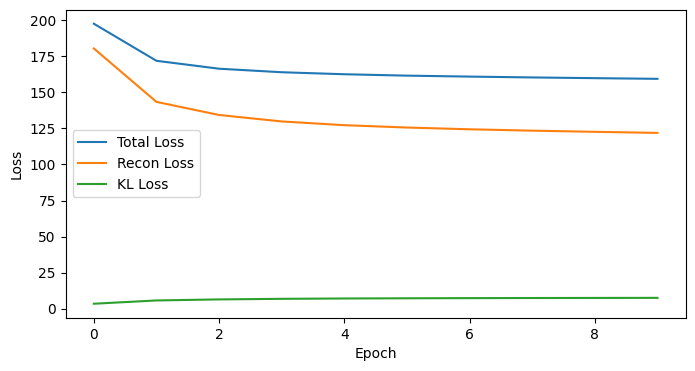

In [26]:
beta = 5.0
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
epochs = 10

history = {'avg_loss': [], 'avg_recon_loss': [], 'avg_kl_loss': []}
model.train()
for epoch in range(1, epochs + 1):
    avg_loss = avg_recon_loss = avg_kl_loss = 0

    for x, _ in tqdm(train_loader, desc = f"beta-VAE Epoch {epoch}/{epochs}", total = len(train_loader)):
        x = x.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss, recon_loss, kl_loss = vae_loss_beta(recon, x, mu, logvar, beta)
        avg_loss += loss.item()
        avg_recon_loss += recon_loss.item()
        avg_kl_loss += kl_loss.item()

        loss.backward()
        optimizer.step()
    avg_loss /= len(train_loader)
    avg_recon_loss /= len(train_loader)
    avg_kl_loss /= len(train_loader)
    history['avg_loss'].append(avg_loss)
    history['avg_recon_loss'].append(avg_recon_loss)
    history['avg_kl_loss'].append(avg_kl_loss)
    print(f"beta-VAE Epoch {epoch}: Loss={avg_loss:.4f}, Recon Loss={avg_recon_loss:.4f}, KL Loss={avg_kl_loss:.4f}")

plt.figure(figsize=(8,4))
plt.plot(history['avg_loss'], label='Total Loss')
plt.plot(history['avg_recon_loss'], label='Recon Loss')
plt.plot(history['avg_kl_loss'], label='KL Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

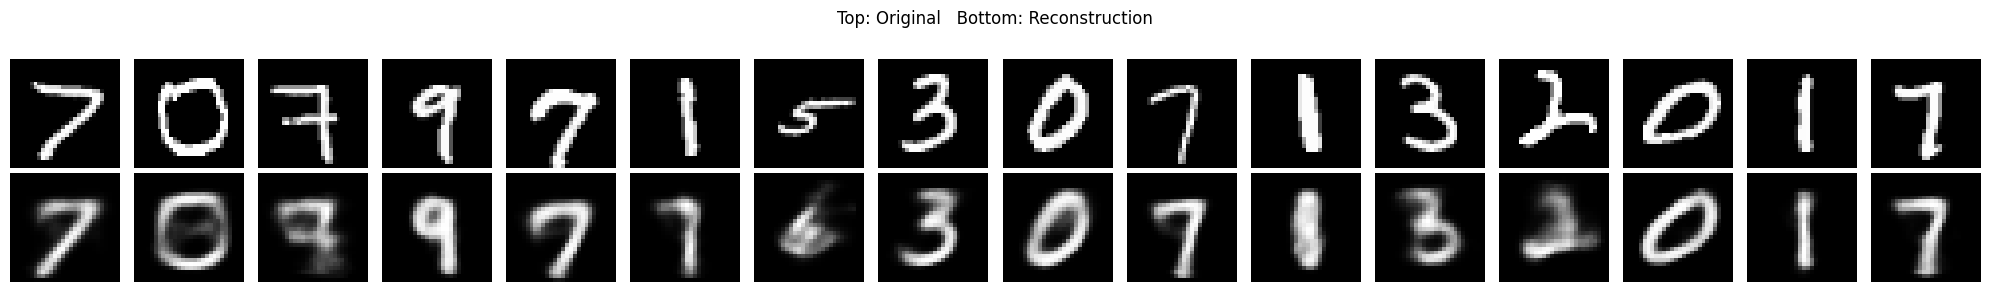

In [27]:
model.eval()

x_test, _ = next(iter(train_loader))
x_sample = x_test[:16].to(device)
with torch.no_grad():
    recon, _, _ = model(x_sample)

fig, axes = plt.subplots(2, 16, figsize=(20,3))
for i in range(16):
    axes[0,i].imshow(x_sample[i].cpu().view(28,28), cmap='gray')
    axes[0,i].axis('off')
    axes[1,i].imshow(recon[i].cpu().detach().view(28,28), cmap='gray')
    axes[1,i].axis('off')
plt.suptitle('Top: Original   Bottom: Reconstruction')
plt.tight_layout()
plt.show()

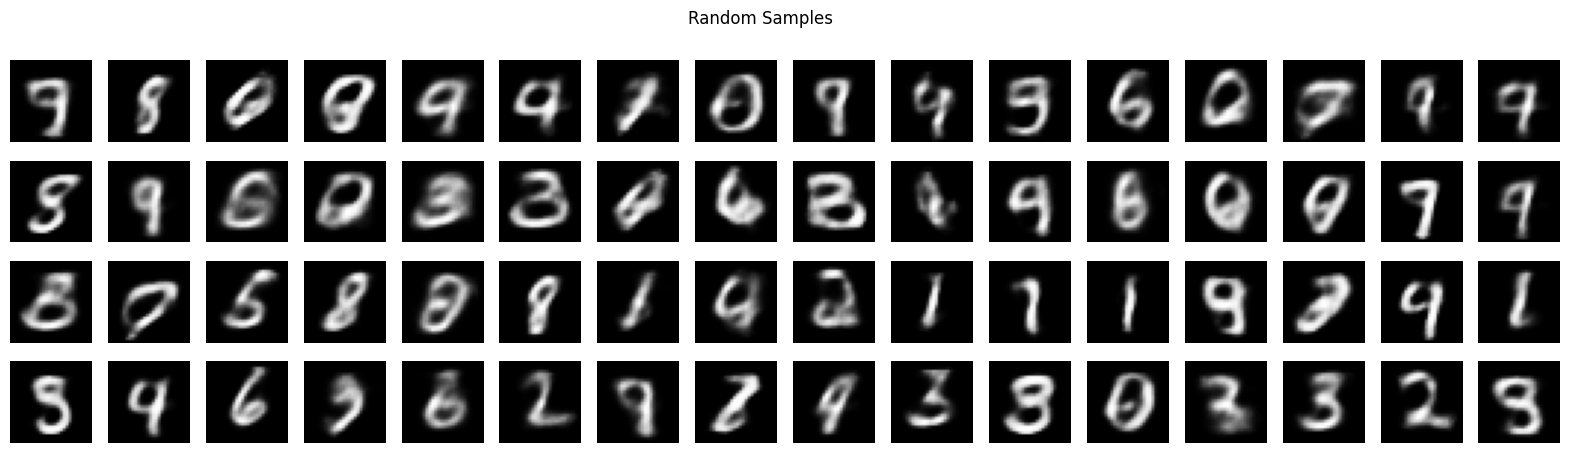

In [28]:
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    samples = model.decode(z)

fig, axes = plt.subplots(4, 16, figsize=(20,5))
for i in range(64):
    axes[i//16, i%16].imshow(samples[i].cpu().view(28,28), cmap='gray')
    axes[i//16, i%16].axis('off')
plt.suptitle('Random Samples'); plt.show()

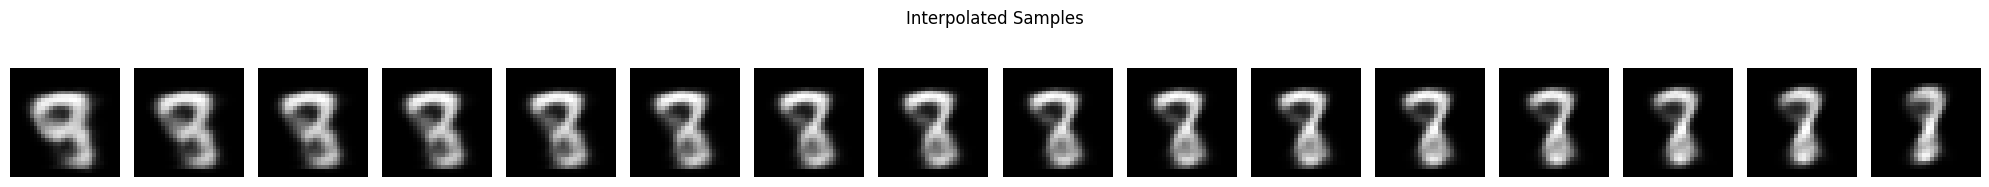

In [29]:
z1 = torch.randn(1, 20)
z2 = torch.randn(1, 20)
weights = np.linspace(0, 1, 16)
z = torch.stack([z1 * np.sqrt(1 - w) + z2 * np.sqrt(w) for w in weights]).to(device)
with torch.no_grad():
    interpolated_samples = model.decode(z)
fig, axes = plt.subplots(1, 16, figsize=(20,2))
for i in range(16):
    axes[i].imshow(interpolated_samples[i].cpu().view(28,28), cmap='gray')
    axes[i].axis('off')
plt.suptitle('Interpolated Samples')
plt.tight_layout()
plt.show()

## 第三部分 预训练模型使用体验

如果加载预训练模型（访问HuggingFace）时遇到网络问题，可以下载[模型文件](https://disk.pku.edu.cn/link/AADCEB4C4CE3804C3CA800BEA82E28ABF8)将其放在本地路径，在加载时指定路径，例如
```python
fill_mask = pipeline("fill-mask", model="path/to/bert-base-uncased", 
                        tokenizer="path/to/bert-base-uncased")  
tokenizer = BertTokenizer.from_pretrained("path/to/bert-base-uncased")
bert = BertModel.from_pretrained("path/to/bert-base-uncased")
```

In [39]:
from transformers import pipeline, BertTokenizer, BertModel
import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

### 3.1 使用BERT进行掩码填充

In [47]:
fill_mask = pipeline("fill-mask", model="bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')
sentence = "It is snowing and the weather is [MASK]."
results = fill_mask(sentence)
for r in results:
    print(r)

The following layers were not sharded: bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, cls.predictions.transform.LayerNorm.weight, bert.encoder.layer.*.output.LayerNorm.bias, cls.predictions.transform.dense.weight, bert.encoder.layer.*.output.dense.bias, cls.predictions.transform.LayerNorm.bias, cls.predictions.decoder.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.embeddings.LayerNorm.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.self.query.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.attention.self.query.weight, bert.encoder.layer.*.attention.output.dense.weight, bert.embeddings.word_embeddings.weight, cls.predictions.decoder.bias, bert.encoder.layer.*.attention.self.key.bias, cls.predict

{'score': 0.21154475212097168, 'token': 3147, 'token_str': 'cold', 'sequence': 'it is snowing and the weather is cold.'}
{'score': 0.1751469373703003, 'token': 4010, 'token_str': 'warm', 'sequence': 'it is snowing and the weather is warm.'}
{'score': 0.0568196065723896, 'token': 3376, 'token_str': 'beautiful', 'sequence': 'it is snowing and the weather is beautiful.'}
{'score': 0.05104368180036545, 'token': 11559, 'token_str': 'sunny', 'sequence': 'it is snowing and the weather is sunny.'}
{'score': 0.04094709828495979, 'token': 4658, 'token_str': 'cool', 'sequence': 'it is snowing and the weather is cool.'}


### 3.2 提取句子特征

以下代码展示了用BERT模型将句子转化为特征向量的过程

In [44]:
# 使用tokenizer进行分词
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text = "He is reading a book in the library"
max_length = 20
encoded = tokenizer(
            text,                   # 要编码的字符串或字符串列表
            truncation=True,        # 超过max_length的文本会被截断（默认在句尾）
            padding='max_length',   # 不足max_length的文本会被填充0（pad token）
            max_length=max_length,  # 指定最大长度
            return_tensors='pt'     # 返回 PyTorch tensor 格式
        )
# input_ids: 形状为 [max_length, ] 的整型张量
#   表示序列中每个 token 在词汇表中的索引
# attention_mask: 形状为 [max_length, ] 的整型张量
#   值为 1 表示该位置是有效的 token，0 表示 padding 部分
print(encoded['input_ids'])
print(encoded['attention_mask'])

tensor([[ 101, 2002, 2003, 3752, 1037, 2338, 1999, 1996, 3075,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [45]:
# 使用BERT模型获取特征
bert = BertModel.from_pretrained('bert-base-uncased')
with torch.no_grad():
    outputs = bert(input_ids=encoded['input_ids'], 
                   attention_mask=encoded['attention_mask'])
print(outputs.last_hidden_state.shape)  # [batch_size, max_length, hidden_size]

# 获取对应于 [CLS] token 的特征，这是句子的整体语义表示向量
cls_feature = outputs.last_hidden_state[:, 0, :]  
print(cls_feature.shape)  # [batch_size, hidden_size]

The following layers were not sharded: encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.self.query.weight, encoder.layer.*.output.LayerNorm.weight, embeddings.LayerNorm.weight, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.self.key.weight, embeddings.LayerNorm.bias, embeddings.token_type_embeddings.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.self.value.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.attention.self.query.bias, embeddings.position_embeddings.weight, encoder.layer.*.attention.self.value.bias, pooler.dense.weight, embeddings.word_embeddings.weight, pooler.dense.bias


torch.Size([1, 20, 768])
torch.Size([1, 768])


### 3.3 句子聚类

本部分中，你需要使用BERT模型提取句子特征，并对这些特征进行聚类。

In [54]:
import torch
import numpy as np
from sklearn.cluster import KMeans

sentences = [
    "I had a bowl of spicy ramen topped with a soft-boiled egg and scallions.",
    "The bakery around the corner makes the best sourdough bread in town.",
    "He tried Ethiopian cuisine for the first time and loved the injera.",
    "Their signature dessert is a matcha cheesecake with a sesame crust.",
    "We spent the afternoon picking fresh strawberries and making jam.",

    "Online learning platforms have transformed how students access knowledge.",
    "She received a scholarship to study biomedical engineering abroad.",
    "The school introduced a new curriculum focused on critical thinking.",
    "Students protested the cancellation of arts programs at the university.",
    "He spent weeks preparing for the SATs and mock interviews."
]

# TODO: 仿照3.2的代码，提取每个句子的 [CLS] 特征
max_length = 20
features = []
bert = BertModel.from_pretrained('bert-base-uncased')

for sentence in sentences:
    encoded = tokenizer(
                sentence,
                truncation=True,
                padding='max_length',
                max_length=max_length,
                return_tensors='pt'
            )
    
    with torch.no_grad():
        outputs = bert(input_ids=encoded['input_ids'], 
                    attention_mask=encoded['attention_mask'])
    
    # cls_feature:获取对应于 [CLS] token 的特征，这是句子的整体语义表示向量
    cls_feature = outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # [batch_size=1, hidden_size] -> [hidden_size],并转换为numpy
    features.append(cls_feature)

features = np.array(features)  # 转换为numpy
# 然后使用KMeans将它们聚为两类，打印结果
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2, random_state = 42)
clusters = kmeans.fit_predict(features)
for sentence, cluster in zip(sentences, clusters):
    print(f"Cluster {cluster}: {sentence}")

The following layers were not sharded: encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.output.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.dense.bias, encoder.layer.*.attention.self.query.weight, encoder.layer.*.output.LayerNorm.weight, embeddings.LayerNorm.weight, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.self.key.weight, embeddings.LayerNorm.bias, embeddings.token_type_embeddings.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.attention.self.value.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.attention.self.query.bias, embeddings.position_embeddings.weight, encoder.layer.*.attention.self.value.bias, pooler.dense.weight, embeddings.word_embeddings.weight, pooler.dense.bias


Cluster 0: I had a bowl of spicy ramen topped with a soft-boiled egg and scallions.
Cluster 0: The bakery around the corner makes the best sourdough bread in town.
Cluster 1: He tried Ethiopian cuisine for the first time and loved the injera.
Cluster 0: Their signature dessert is a matcha cheesecake with a sesame crust.
Cluster 1: We spent the afternoon picking fresh strawberries and making jam.
Cluster 1: Online learning platforms have transformed how students access knowledge.
Cluster 1: She received a scholarship to study biomedical engineering abroad.
Cluster 1: The school introduced a new curriculum focused on critical thinking.
Cluster 1: Students protested the cancellation of arts programs at the university.
Cluster 1: He spent weeks preparing for the SATs and mock interviews.
